# Face Alignment

## Архитектура Stacked Hourglass Network

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.49.50_PM.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.50.12_PM.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок иммеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [7]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

#         self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
#         self.bn1 = nn.BatchNorm2d(out_channels // 2)
#         self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels // 2)
#         self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
#         self.bn3 = nn.BatchNorm2d(out_channels)

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         residual = self.skip(x)
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.bn3(self.conv3(x))
#         return self.relu(x + residual)

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Датасет

Есть множество датасетов для этой задачи, но для наших целей должно хватить и [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). К сожалению или к счастью в разметке там всего 5 точек

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

Сам по себе CelebA избыточно большой для нашей задачи, поэтому можете использовать только его часть. Также, имеет смысл заранее кропнуть картинки таким образом, чтобы на них остались только лица, ну или по крайней мере минимум всего остального.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

# Реализация

### Hourglass блок

In [8]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import MSELoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
import os
import torchvision.transforms as transforms
import math
from PIL import Image

from models import StackedHourglass


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device



device(type='cuda')

## Теперь нужен датасет

In [ ]:


class CelebALightweightDataset(Dataset):
    def __init__(self, root='./data', split='train', transform=None):
        self.original_dataset = torchvision.datasets.CelebA(
            root=root,
            split=split,
            target_type="landmarks",
            download=True 
        )
        self.transform = transform
        self.root = self.original_dataset.root
        self.base_folder = getattr(self.original_dataset, 'base_folder', 'celeba')


    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        raw_item = self.original_dataset[idx]
        if isinstance(raw_item[0], str): 
             filename, landmarks_raw = raw_item
             img_path = os.path.join(self.root, self.base_folder, "img_align_celeba", filename)
             img = default_loader(img_path)
        else: 
            img, landmarks_raw = raw_item

        if self.transform:
            img = self.transform(img)

        landmarks = landmarks_raw.view(5, 2).float()
        landmarks[:, 0] /= 178
        landmarks[:, 1] /= 218
        
        return img, landmarks

In [10]:
import torch

def batch_landmarks_to_heatmaps(landmarks, output_size, sigma=2, device='cpu'):
    """
    Преобразует батч из N точек в набор из N heatmap'ов на GPU.
    :param landmarks: torch.Tensor [B, N, 2] - батч координат (x, y) в диапазоне [0, 1]
    :param output_size: (H, W) - размер heatmap'ов
    :return: torch.Tensor [B, N, H, W] - батч heatmap'ов
    """
    B, N, _ = landmarks.shape
    H, W = output_size

    landmarks_scaled = landmarks * torch.tensor([W, H], device=device, dtype=torch.float32).view(1, 1, 2)

    xx, yy = torch.meshgrid(
        torch.arange(W, device=device, dtype=torch.float32), 
        torch.arange(H, device=device, dtype=torch.float32), 
        indexing='xy'
    )

    xx_b = xx.view(1, 1, H, W).expand(B, N, -1, -1)
    yy_b = yy.view(1, 1, H, W).expand(B, N, -1, -1)
    
    x_b = landmarks_scaled[:, :, 0].view(B, N, 1, 1)
    y_b = landmarks_scaled[:, :, 1].view(B, N, 1, 1)

    heatmaps = torch.exp(-((yy_b - y_b)**2 + (xx_b - x_b)**2) / (2 * sigma**2))

    return heatmaps


Размер тренировочного набора: 162770
Размер валидационного набора: 19867

Проверка загруженных данных...


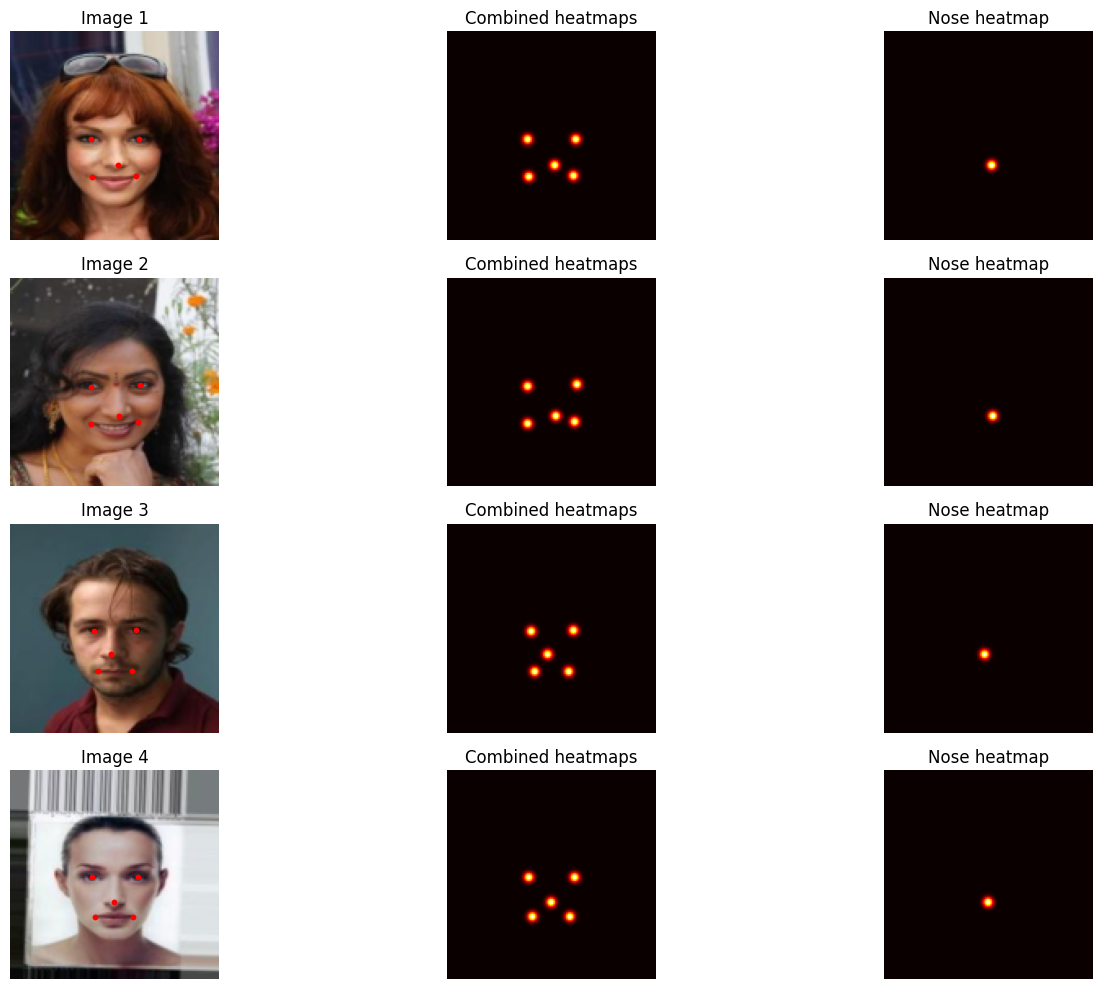

In [11]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

IMAGE_SIZE = 128
BATCH_SIZE = 32 
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataset = CelebALightweightDataset(split='train', transform=transform)
valid_dataset = CelebALightweightDataset(split='valid', transform=transform)

# num_workers != 0 на винде у меня не работает
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

print(f"\nРазмер тренировочного набора: {len(train_dataset)}")
print(f"Размер валидационного набора: {len(valid_dataset)}")

print("\nПроверка загруженных данных...")
images, landmarks = next(iter(train_loader))


heatmaps_for_viz = batch_landmarks_to_heatmaps(landmarks, (IMAGE_SIZE, IMAGE_SIZE), sigma=2, device='cpu')

plt.figure(figsize=(15, 10))
for i in range(min(4, images.shape[0])):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(images[i].permute(1, 2, 0))
    pts = landmarks[i] * torch.tensor([IMAGE_SIZE, IMAGE_SIZE]).view(1, 2)
    plt.scatter(pts[:, 0], pts[:, 1], s=10, c='r')
    plt.axis('off')
    plt.title(f"Image {i+1}")
    
    plt.subplot(4, 3, i*3+2)
    plt.imshow(heatmaps_for_viz[i].sum(dim=0), cmap='hot')
    plt.axis('off')
    plt.title("Combined heatmaps")
    
    plt.subplot(4, 3, i*3+3)
    plt.imshow(heatmaps_for_viz[i][2], cmap='hot')
    plt.axis('off')
    plt.title("Nose heatmap")

plt.tight_layout()
plt.show()

In [ ]:
IMAGE_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
CHECKPOINT_PATH = 'models/align_learning_model.pth' 

model = StackedHourglass(num_outputs=5, feature_size=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-4)
criterion = MSELoss()

start_epoch = 0
train_losses = []
val_losses = []

# model.load_state_dict(torch.load(CHECKPOINT_PATH))

# Если гпу рич
# if torch.cuda.device_count() > 1:
#     model = torch.nn.DataParallel(model)
# сделал еще вариант скрипта с акселерейт

model.to(device)

    


def compute_loss(outputs, targets):
    total_loss = 0
    for output in outputs:
        if output.shape[-2:] != targets.shape[-2:]:
             output = transforms.functional.resize(output, targets.shape[-2:], antialias=True)
        total_loss += criterion(output, targets)
    return total_loss

def visualize_progress(model, dataloader, device, epoch):
    model.eval()
    with torch.no_grad():
        images, true_landmarks = next(iter(dataloader))
        images = images.to(device)
        
        pred_heatmaps = model(images)[-1]
        
        images = images.cpu()
        pred_heatmaps = pred_heatmaps.cpu()
        true_landmarks = true_landmarks.cpu()

        num_images_to_show = min(12, images.shape[0]) 
        fig, axes = plt.subplots(2, num_images_to_show, figsize=(num_images_to_show * 4, 8))
        fig.suptitle(f'Результаты после эпохи {epoch + 1}', fontsize=16)

        for i in range(num_images_to_show):
            ax = axes[0, i]
            ax.imshow(images[i].permute(1, 2, 0))
            true_pts = true_landmarks[i] * torch.tensor([IMAGE_SIZE, IMAGE_SIZE])
            ax.scatter(true_pts[:, 0], true_pts[:, 1], s=30, c='lime', marker='o', edgecolors='black', label='True')
            ax.set_title(f'Истинные точки (Img {i+1})')
            ax.axis('off')

            pred_coords = []
            for j in range(pred_heatmaps.shape[1]): 
                hm = pred_heatmaps[i, j]
                y, x = np.unravel_index(np.argmax(hm), hm.shape)
                pred_coords.append([x, y])
            pred_coords = np.array(pred_coords)

            ax = axes[1, i]
            ax.imshow(images[i].permute(1, 2, 0))
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], s=35, c='red', marker='x', label='Pred')
            ax.set_title(f'Предсказания (Img {i+1})')
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    for images, landmarks in tqdm(train_loader, desc=f'Эпоха {epoch+1}/{NUM_EPOCHS} [Train]'):
        images = images.to(device)
        heatmaps = batch_landmarks_to_heatmaps(landmarks.to(device), (IMAGE_SIZE, IMAGE_SIZE), sigma=2, device=device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = compute_loss(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_train_loss += loss.item()
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for images, landmarks in tqdm(valid_loader, desc=f'Эпоха {epoch+1}/{NUM_EPOCHS} [Valid]'):
            images = images.to(device)
            heatmaps = batch_landmarks_to_heatmaps(landmarks.to(device), (IMAGE_SIZE, IMAGE_SIZE), sigma=2, device=device)
            outputs = model(images)
            loss = compute_loss(outputs, heatmaps)
            epoch_val_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(valid_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    
    torch.save(model.state_dict(), CHECKPOINT_PATH)

    print(f'Эпоха {epoch+1}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    print(f'Чекпоинт сохранен в {CHECKPOINT_PATH}')

    visualize_progress(model, valid_loader, device, epoch)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('График потерь при обучении')
plt.show()

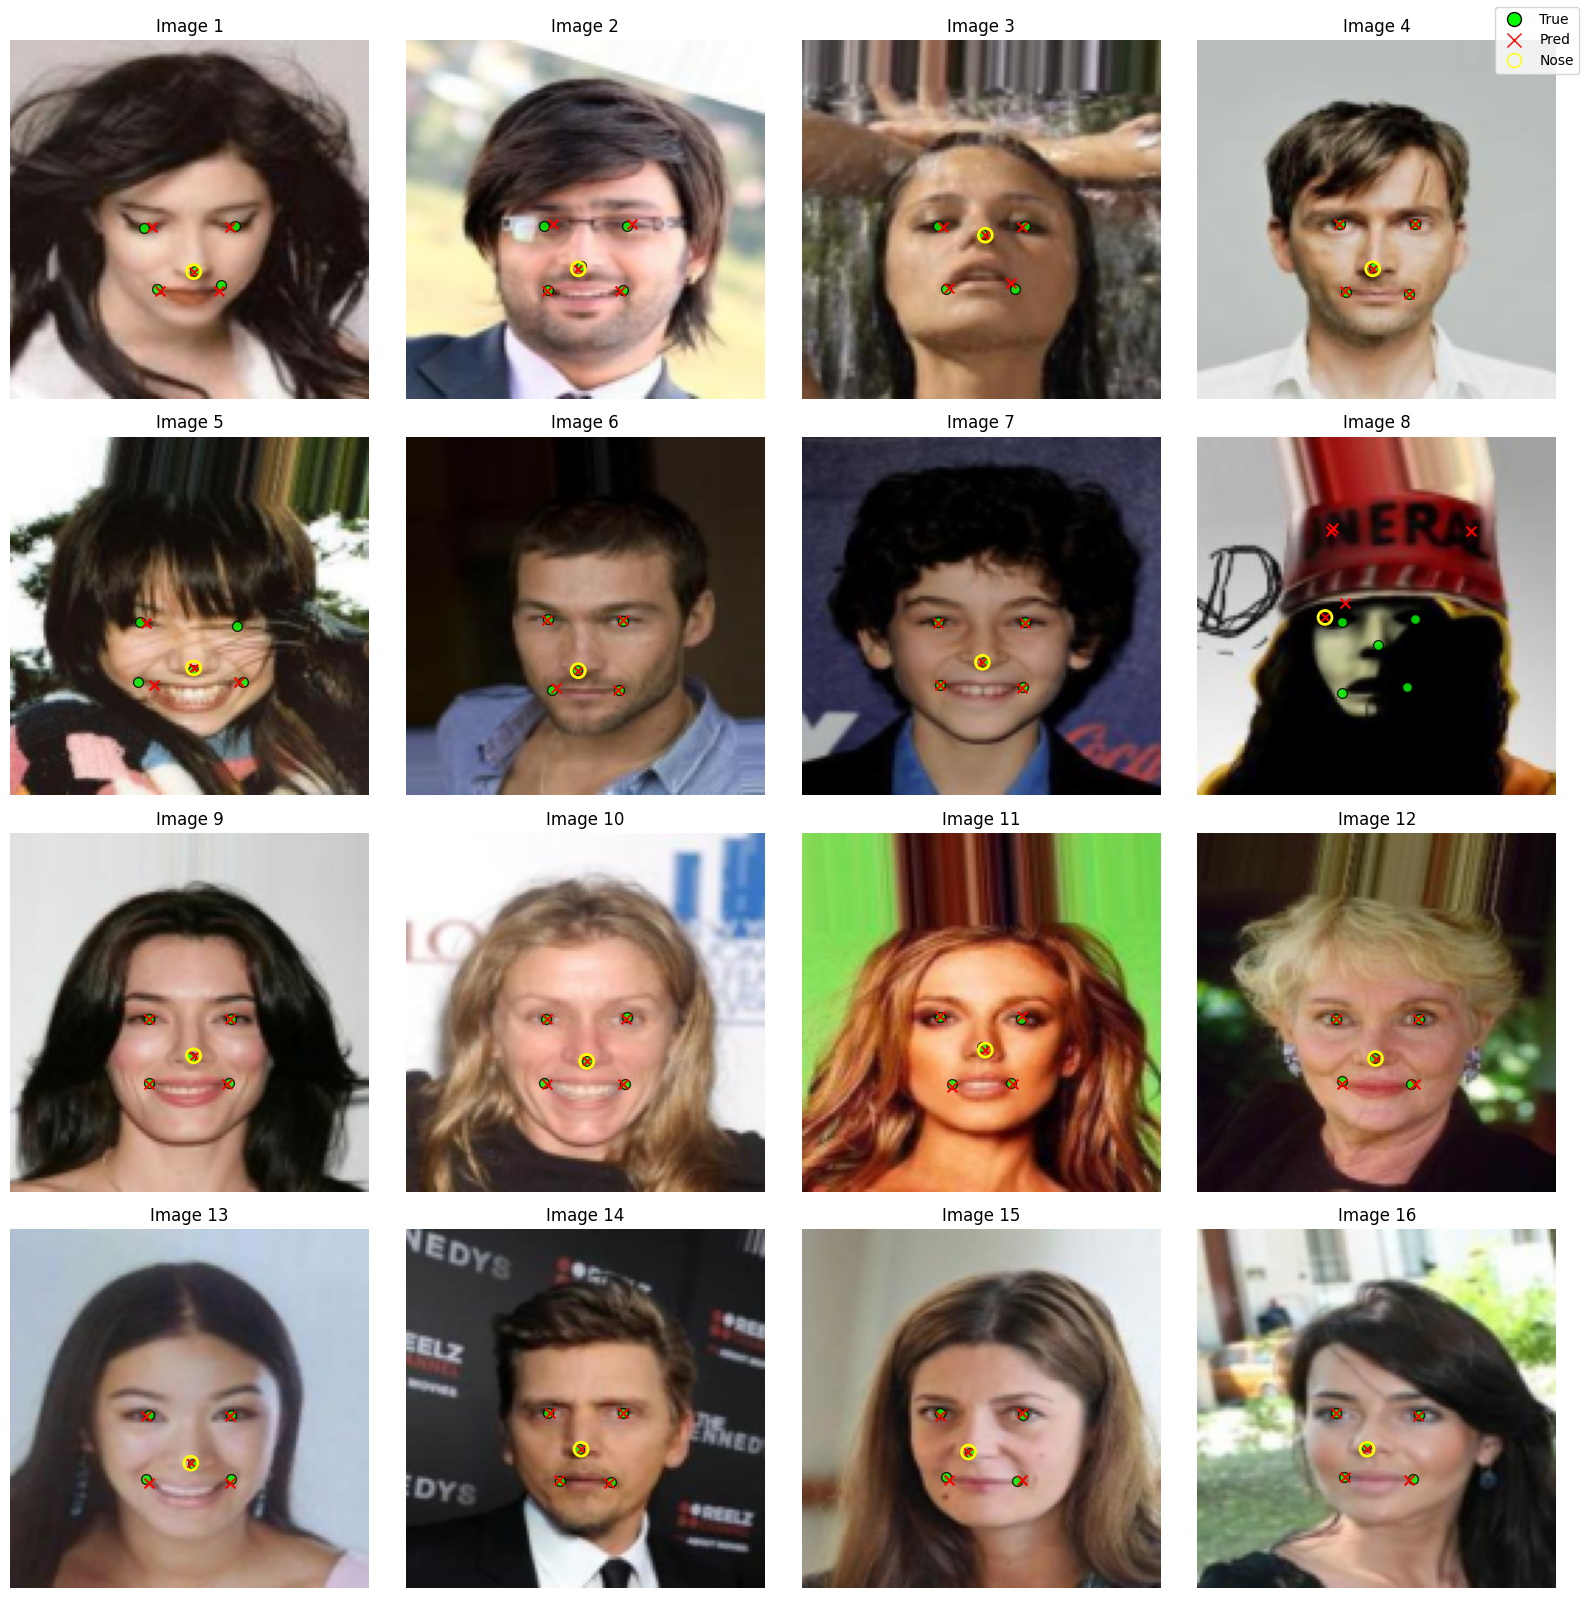

In [17]:

def visualize_many_predictions(model, dataloader, device, num_images=16, image_size=128):
    model.eval()
    images_so_far = 0
    cols = 4
    rows = math.ceil(num_images / cols)
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    pil_to_tensor = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
                true_landmarks = batch[1]
            else:
                images = batch
                true_landmarks = None
                
            if isinstance(images, list) and isinstance(images[0], Image.Image):
                images = torch.stack([pil_to_tensor(img) for img in images])
            
            images = images.to(device)
            pred_heatmaps_list = model(images)
            pred_heatmaps = pred_heatmaps_list[-1]
            for j in range(images.shape[0]):
                if images_so_far >= num_images:
                    break
                ax = fig.add_subplot(rows, cols, images_so_far + 1)
                img_tensor = images[j].cpu()
                
                if img_tensor.min() < 0 or img_tensor.max() > 1:
                    img_tensor = (img_tensor - img_tensor.min()) 
                    img_tensor = img_tensor / img_tensor.max()
                img_display = img_tensor.permute(1, 2, 0).numpy()
                ax.imshow(img_display)
                
                if true_landmarks is not None:
                    true_pts = true_landmarks[j].cpu().numpy() * image_size
                    ax.scatter(true_pts[:, 0], true_pts[:, 1], s=50, c='lime', 
                              marker='o', alpha=0.8, edgecolors='black')
                pred_coords = []
                for k in range(pred_heatmaps.shape[1]):
                    hm = pred_heatmaps[j, k].cpu().numpy()
                    y, x = np.unravel_index(np.argmax(hm), hm.shape)
                    pred_coords.append([x, y])
                pred_coords = np.array(pred_coords)
                
                ax.scatter(pred_coords[:, 0], pred_coords[:, 1], s=50, 
                          c='red', marker='x')
                ax.scatter(pred_coords[2, 0], pred_coords[2, 1], s=100, 
                          facecolors='none', edgecolors='yellow', linewidth=2)
                ax.set_title(f"Image {images_so_far + 1}")
                ax.axis('off')
                images_so_far += 1
            if images_so_far >= num_images:
                break
    
    handles = [
        plt.Line2D([], [], color='lime', marker='o', linestyle='None',
                  markersize=10, label='True', markeredgecolor='black'),
        plt.Line2D([], [], color='red', marker='x', linestyle='None',
                  markersize=10, label='Pred'),
        plt.Line2D([], [], color='yellow', marker='o', linestyle='None',
                  markersize=10, label='Nose', markeredgecolor='yellow', fillstyle='none')
    ]
    
    fig.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.show()

model.to(device)
model.load_state_dict(torch.load('models/aligner.pth'))

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor() 
])

valid_dataset = CelebALightweightDataset(split='valid', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

visualize_many_predictions(model, valid_loader, device, num_images=16, image_size=IMAGE_SIZE)